Cleaned version of v2

# Load libraries

In [11]:
#### Import librairies
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
from importlib import reload
import warnings
import healpy as hp
import collections
from collections import namedtuple

sys.path.insert(1,'../script/')
import cutout_img_dc2
import plot

In [2]:
import FoFCatalogMatching
import GCRCatalogs
GCRCatalogs.set_root_dir_by_site('in2p3')
import fitsio

import lsst.afw.geom as afw_geom
import lsst.afw.table as afw_table
import lsst.daf.persistence as dp
import lsst.daf.persistence as dafPersist
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.geom

In [3]:
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.visualization import ZScaleInterval
from astropy.table import Table

In [4]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (6, 6)
zscale = ZScaleInterval()

# Test with GCR Catalogs

## Read in metacal catalog (not used here)

In [5]:
# Read in the metacal galaxy catalog data.
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    gc_obs_metacal = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_wfd_with_metacal')#run2.2i-coadd-wfd-dr6-v1

## Read in observed catalog

In [6]:
# Read in the galaxy catalog data.
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    gc_obs = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_wfd')#run2.2i-coadd-wfd-dr6-v1

## Match with true catalog

In [5]:
# Read in the galaxy catalog data.
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

Select data from the right tract and apply the cut in magnitude

In [7]:
# Let's define a magnitude cut
mag_filters = [
    (np.isfinite, 'mag_r'),
    'mag_r < 26.5',
]

In [8]:
# Load ra and dec from object, using both of the filters we just defined.
object_data = gc_obs.get_quantities(['ra', 'dec', 'mag_r','mag_r_cModel' , 'snr_r_cModel',
                                     'ext_shapeHSM_HsmShapeRegauss_e1', 'ext_shapeHSM_HsmShapeRegauss_e2',
                                    'blendedness'],
                                        filters=(mag_filters), native_filters=['tract == 4855'])

/pbs/home/b/barcelin/pbs_throng_link/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/pbs/home/b/barcelin/pbs_throng_link/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


Now use the data from the observe catalog to apply filter in position and magnitude on true catalog

In [12]:
max_ra = np.nanmax(object_data['ra'])
min_ra = np.nanmin(object_data['ra'])
max_dec = np.nanmax(object_data['dec'])
min_dec = np.nanmin(object_data['dec'])
vertices = hp.ang2vec(np.array([min_ra, max_ra, max_ra, min_ra]),
                      np.array([min_dec, min_dec, max_dec, max_dec]), lonlat=True)
ipix = hp.query_polygon(32, vertices, inclusive=True)
native_filter = f'(healpix_pixel == {ipix[0]})'
for ipx in ipix:
    native_filter=native_filter+f' | (healpix_pixel == {ipx})'
pos_filters=[f'ra >= {min_ra}',f'ra <={max_ra}', f'dec >= {min_dec}', f'dec <= {max_dec}']

truth_mag_filters = ['mag_r < 26.5']
quantities = ['galaxy_id', 'ra', 'dec', 
              'mag_r', 'mag_r_lsst',
              'redshift',
              'ellipticity_true', 'convergence',
              'ellipticity_1_true', 'ellipticity_2_true',
              'ellipticity_1', 'ellipticity_2',
              'morphology/totalEllipticity1', 'morphology/totalEllipticity2', 
              'shear_1', 'shear_2']
truth_data = gc.get_quantities(quantities, filters=truth_mag_filters+pos_filters, 
                                      native_filters=native_filter)

ValueError: Native quantity `ellipticity_2` does not exist (required by `ellipticity_2`)

Match the catalogs

In [11]:
# now we can really do the matching!
# FoFCatalogMatching.match takes a dictionary of catalogs to match, a friends-of-friends linking length. 
# Because our "catalog" is not an astropy table or pandas dataframe, 
# `len(truth_coord)` won't give the actual length of the table
# so we need to specify `catalog_len_getter` so that the code knows how to get the length of the catalog.

results = FoFCatalogMatching.match(
    catalog_dict={'truth': truth_data, 'object': object_data},
    linking_lengths=1.,#{5.0: 5, 4.0: 5, 3.0: 4, 2.0: 3, 1.0: None}, # Linking length of 1 arcsecond, you can play around with the values!
    catalog_len_getter=lambda x: len(x['ra']),
)

In [12]:
len(truth_data['ra']), len(object_data['ra'])

(720922, 604159)

## Use matching to edit a list of (ra,dec) coordinates to plot target galaxy

In [13]:
# first we need to know which rows are from the truth catalog and which are from the object
truth_mask = results['catalog_key'] == 'truth'
object_mask = ~truth_mask


# then np.bincount will give up the number of id occurrences (like historgram but with integer input)
n_groups = results['group_id'].max() + 1
n_truth = np.bincount(results['group_id'][truth_mask], minlength=n_groups)
n_object = np.bincount(results['group_id'][object_mask], minlength=n_groups)

Let's further inspect the objects in the groups that have 1-to-1 truth/object match.
First, let's find our the IDs of the groups that have 1-to-1 truth/object match:

In [14]:
one_to_one_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_truth == 1) & (n_object == 1)))

and then we can find the row indices in the *original* truth/object catalogs for those 1-to-1 groups

In [15]:
truth_idx = results['row_index'][one_to_one_group_mask & truth_mask]
object_idx = results['row_index'][one_to_one_group_mask & object_mask]

## Load image catalog through butler

Load butler to retrieve images of target galaxies

In [16]:
repo = '/sps/lssttest/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1-grizy'
butler = dafPersist.Butler(repo)

## Explore object_data dictionnary

In [17]:
id_ra_dec = Table.from_pandas(pd.DataFrame.from_dict(object_data))

In [18]:
id_ra_dec

<Table length=604159>
      mag_r           mag_r_cModel    ...         dec        
     float64            float64       ...       float64      
------------------ ------------------ ... -------------------
26.481265045720434  25.68015692073079 ...  -29.75205858692462
25.198341776003225  24.93244129131201 ...  -29.75184812311894
25.804960924490835 25.806626045303236 ... -29.751486077180644
 26.01826400470061  25.59764194598977 ... -29.751980202879626
 25.15278461269007 24.996537185656884 ... -29.751696983918773
  25.0459491064264 24.934889507003238 ... -29.751104508535818
25.105719930503692 24.788687454349557 ...  -29.75113749414679
 25.92396390523416 25.425340773634105 ...  -29.75044584016431
 25.80159593230449  25.45265269218033 ... -29.751151947764765
25.484156601932483  25.47089601093768 ...  -29.75030352875106
               ...                ... ...                 ...
26.341874945544006  25.93171373675395 ...  -28.27907207556659
26.268457605796936 26.236425592922817 ... -28.277536983181744
26.090811931159827 25.986324200190406 ...  -28.27803473731411
26.423046636825532   26.4062106844355 ...  -28.27783478838995
26.485614911561566  26.48694338341836 ... -28.276790957039033
26.339998736789262 26.318570410277307 ...  -28.27644480475509
 26.45063473825848 26.108196408067528 ...  -28.27128071847276
26.468233801044363 26.432003161748902 ... -28.267675863843632
 26.43187302398664 26.356075070513555 ...  -28.26760384532562
 26.21342229648495 26.197353085484238 ...  -28.26772119901522

## Generate galaxy image giving (ra,dec) coordinates

522424 2


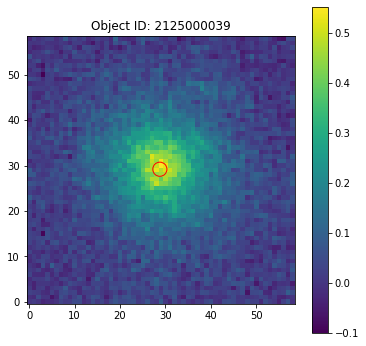

e1 true: -0.008787835780120599
e2 true: -0.05306470249307474
shear_1 true: -0.0
shear_2 true: 0.0
redshift true: 0.02078760956426784


In [21]:
# Plot just one
i = 2
first = id_ra_dec[object_idx[i]]
print(object_idx[i], truth_idx[i])
ra, dec = first['ra'], first['dec']
frame = 0
plt.figure(frame)
cutout = cutout_img_dc2.make_cutout_image(butler, ra, dec, filter='r', label="Object ID: %d" % truth_data['galaxy_id'][truth_idx[i]])

print('e1 true: '+str(truth_data['ellipticity_1_true'][truth_idx[i]]))
print('e2 true: '+str(truth_data['ellipticity_2_true'][truth_idx[i]]))
print('shear_1 true: '+str(truth_data['shear_1'][truth_idx[i]]))
print('shear_2 true: '+str(truth_data['shear_2'][truth_idx[i]]))
print('redshift true: '+str(truth_data['redshift'][truth_idx[i]]))

test for data augmentation: flip and switching axes

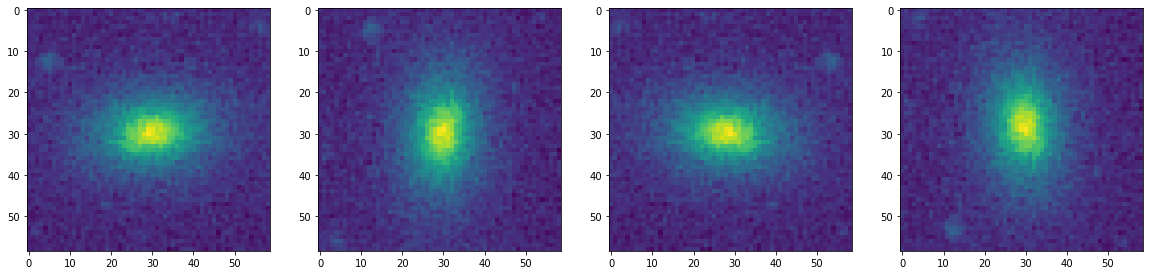

In [20]:
fig, axes = plt.subplots(1,4, figsize = (20,5))
axes[0].imshow(cutout.image.array)#, origin = 'lower')
axes[1].imshow(np.swapaxes(cutout.image.array, 1, 0))#, origin = 'lower')
axes[2].imshow(np.flip(cutout.image.array, axis = 1))#, origin = 'lower')
axes[3].imshow(np.swapaxes(np.flip(cutout.image.array, axis = 1),1,0))#, origin = 'lower')

In [22]:
cutout.image.array.shape

(59, 59)

520632 0


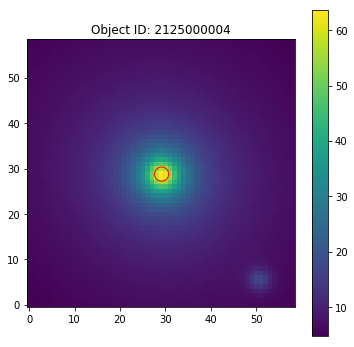

e1 true: -0.020480165393170054
e2 true: -0.05912438897085703
shear_1 true: -0.0
shear_2 true: 0.0
redshift true: 0.010269957322831536


In [23]:
# Plot just one
i = 0
first = id_ra_dec[object_idx[i]]
print(object_idx[i], truth_idx[i])
ra, dec = first['ra'], first['dec']
frame = 0
plt.figure(frame)
cutout = cutout_img_dc2.make_cutout_image(butler, ra, dec, filter='r', label="Object ID: %d" % truth_data['galaxy_id'][truth_idx[i]])

print('e1 true: '+str(truth_data['ellipticity_1_true'][truth_idx[i]]))
print('e2 true: '+str(truth_data['ellipticity_2_true'][truth_idx[i]]))
print('shear_1 true: '+str(truth_data['shear_1'][truth_idx[i]]))
print('shear_2 true: '+str(truth_data['shear_2'][truth_idx[i]]))
print('redshift true: '+str(truth_data['redshift'][truth_idx[i]]))

## Check that object and truth data are indeed matched correclty

### Check part of the sky

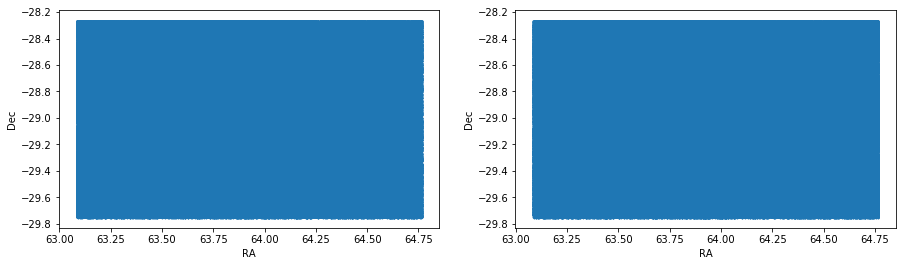

In [24]:
fig, axes = plt.subplots(1,2, figsize = (15,4))
axes[0].scatter(object_data['ra'], object_data['dec'], s=1, rasterized=True);
axes[1].scatter(truth_data['ra'], truth_data['dec'], s=1, rasterized=True);

axes[0].set_xlabel('RA');
axes[0].set_ylabel('Dec');

axes[1].set_xlabel('RA');
axes[1].set_ylabel('Dec');

### Check magnitudes

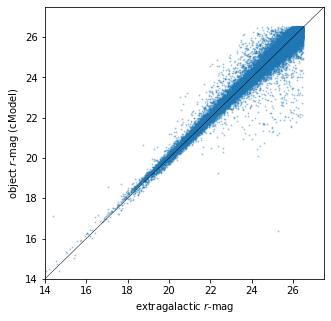

In [49]:
plt.figure(figsize=(5,5));
plt.scatter(truth_data['mag_r_lsst'][truth_idx[:100000]], object_data['mag_r_cModel'][object_idx[:100000]], s=1, alpha = 0.3);
lims = [14, 27.5]
plt.plot(lims, lims, c='k', lw=0.5);
plt.xlabel('extragalactic $r$-mag');
plt.ylabel('object $r$-mag (cModel)');
plt.xlim(lims);
plt.ylim(lims);

### Check total ellipticities

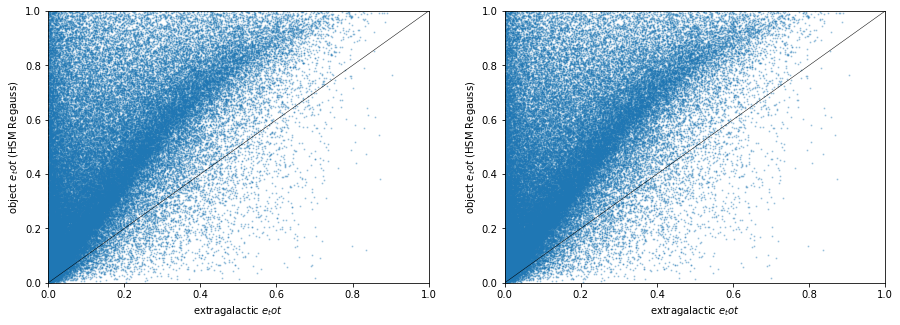

In [50]:
fig, axes = plt.subplots(1,2, figsize=(15,5));
ellipticity_obs= np.hypot(object_data['ext_shapeHSM_HsmShapeRegauss_e1'], object_data['ext_shapeHSM_HsmShapeRegauss_e2'])
axes[0].scatter(truth_data['ellipticity_true'][truth_idx[:100000]], ellipticity_obs[object_idx[:100000]], s=1, alpha = 0.3);
lims = [0, 1]
axes[0].plot(lims, lims, c='k', lw=0.5);
axes[0].set_xlabel('extragalactic $e_tot$');
axes[0].set_ylabel('object $e_tot$ (HSM Regauss)');
axes[0].set_xlim(lims);
axes[0].set_ylim(lims);


ellipticity_truth = np.hypot(truth_data['ellipticity_1_true'],truth_data['ellipticity_2_true'])
axes[1].scatter(ellipticity_truth[truth_idx[:100000]], ellipticity_obs[object_idx[:100000]], s=1, alpha = 0.3);
lims = [0, 1]
axes[1].plot(lims, lims, c='k', lw=0.5);
axes[1].set_xlabel('extragalactic $e_tot$');
axes[1].set_ylabel('object $e_tot$ (HSM Regauss)');
axes[1].set_xlim(lims);
axes[1].set_ylim(lims);

The ellipticity comparison plot above is quite surprising. 
It seems that the ellipticities in the object catalog are generally higher (i.e., less round) than those in the extragalactic catalog. 

The quantity `shape_hsm_regauss_etot` that we used for the object catalog are the re-Gaussianization shapes, which are PSF corrected, and they could be either rounder (if the correction was an under-correction) or less round (if the correction was an over-correction). Hence, their value being systematically larger than the "truth" from extragalactic catalog seems problematic. 

Before we panic, we should, however, remind ourselves of the definition of ellipticities used in these catalogs. 
For the extragalactic catalog, ellipticity is defined as $(1-q)/(1+q)$, where $q$ is the minor-to-major axis ratio
(see the [SCHEMA](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md#schema-for-extragalatic-catalogs)). 
On the other hand, for the object catalog, the HSM re-Gaussianization ellipticity that we are using is defined as $(1-q^2)/(1+q^2)$
(see e.g., Eq. 8 of [Mandelbaum et al. 2006](https://arxiv.org/abs/astro-ph/0511164)).

Hence their definitions are in fact different, so we need to do a conversion before we compare them.
With some math, we can find the conversion between the two definitions $e_{\rm HSM~def} = \frac{2e_{\rm EGC~def}}{1+e_{\rm EGC~def}^2}$.

In [52]:
ellipticity_conversion = lambda e: 2*e / (1.0+e*e)

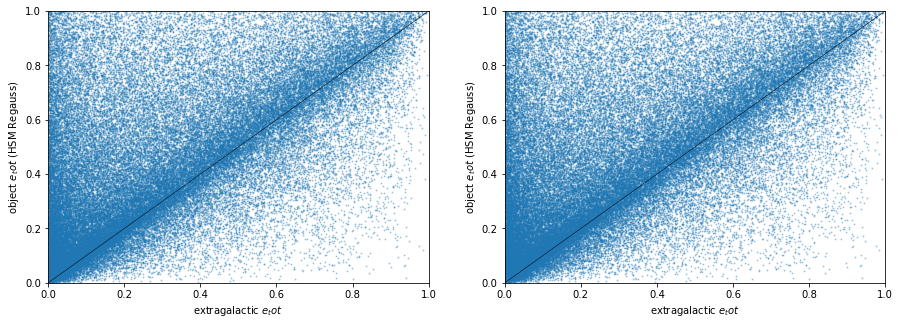

In [53]:
fig, axes = plt.subplots(1,2, figsize=(15,5));
ellipticity_obs= np.hypot(object_data['ext_shapeHSM_HsmShapeRegauss_e1'], object_data['ext_shapeHSM_HsmShapeRegauss_e2'])
axes[0].scatter(ellipticity_conversion(truth_data['ellipticity_true'][truth_idx[:100000]]), ellipticity_obs[object_idx[:100000]], s=1, alpha = 0.3);
lims = [0, 1]
axes[0].plot(lims, lims, c='k', lw=0.5);
axes[0].set_xlabel('extragalactic $e_tot$');
axes[0].set_ylabel('object $e_tot$ (HSM Regauss)');
axes[0].set_xlim(lims);
axes[0].set_ylim(lims);


ellipticity_truth = np.hypot(truth_data['ellipticity_1_true'],truth_data['ellipticity_2_true'])
axes[1].scatter(ellipticity_conversion(ellipticity_truth[truth_idx[:100000]]), ellipticity_obs[object_idx[:100000]], s=1, alpha = 0.3);
lims = [0, 1]
axes[1].plot(lims, lims, c='k', lw=0.5);
axes[1].set_xlabel('extragalactic $e_tot$');
axes[1].set_ylabel('object $e_tot$ (HSM Regauss)');
axes[1].set_xlim(lims);
axes[1].set_ylim(lims);

This looks much better now! 

When you were checking the [SCHEMA](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md#schema-for-extragalatic-catalogs)) file,
you probably have also noticed that `ellipticity_true` is the ellipticity before the shear is applied (i.e., unlensed). 
Hence this comparison is still not an apples-to-apples comparison, as the ellipticity in the object catalog is, of course, lensed. 

According to the [SCHEMA](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md#schema-for-extragalatic-catalogs)), we should have been using `ellipticity` from the extragalactic catalog.
But unfortunately, this quantity is not directly available from the extragalactic catalog!

In [54]:
def calc_lensed_ellipticity(es1, es2, gamma1, gamma2, kappa):
    gamma = gamma1 + gamma2*1j # shear (as a complex number)
    es =  es1 + es2*1j # intrinsic ellipticity (as a complex number)#
    g = gamma / (1.0 - kappa) # reduced shear
    e = (es + g) / (1.0 + g.conjugate()*es) # lensed ellipticity
    return np.absolute(e)


In [81]:
gc.add_derived_quantity('ellipticity', calc_lensed_ellipticity, 
                                       'ellipticity_1_true', 'ellipticity_2_true', 'shear_1', 'shear_2', 'convergence')

ValueError: quantity name `ellipticity` already exists

In [57]:
quantities = ['galaxy_id', 'ra', 'dec', 
              'mag_r', 'mag_r_lsst',
              'redshift',
              'ellipticity_true', 'ellipticity',
              'ellipticity_1_true', 'ellipticity_2_true',
              'shear_1', 'shear_2']
truth_data = gc.get_quantities(quantities, filters=truth_mag_filters+pos_filters, 
                                      native_filters=native_filter)

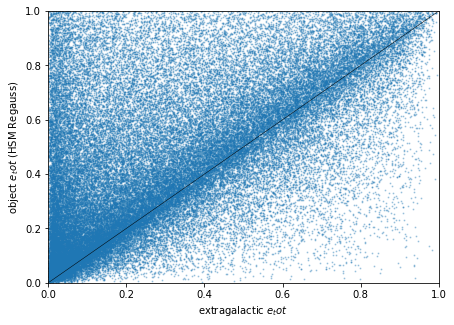

In [58]:
plt.figure(figsize=(7,5));
ellipticity_obs= np.hypot(object_data['ext_shapeHSM_HsmShapeRegauss_e1'], object_data['ext_shapeHSM_HsmShapeRegauss_e2'])
plt.scatter(ellipticity_conversion(truth_data['ellipticity'][truth_idx[:100000]]), ellipticity_obs[object_idx[:100000]], s=1, alpha = 0.3);
lims = [0, 1]
plt.plot(lims, lims, c='k', lw=0.5);
plt.xlabel('extragalactic $e_tot$');
plt.ylabel('object $e_tot$ (HSM Regauss)');
plt.xlim(lims);
plt.ylim(lims);

### Check $e_1$ and $e_2$

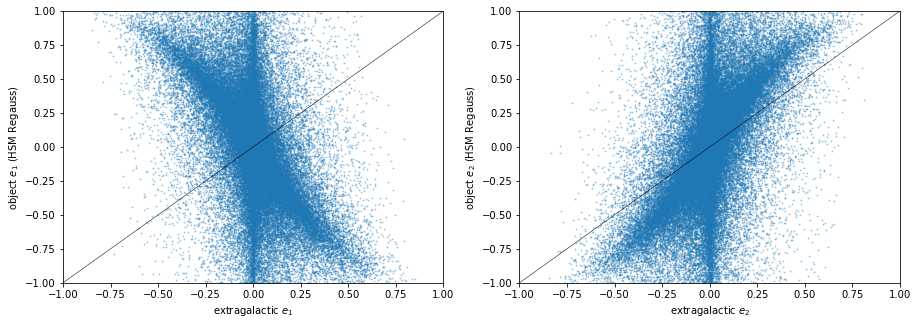

In [59]:
fig, axes = plt.subplots(1,2, figsize=(15,5));
axes[0].scatter(truth_data['ellipticity_1_true'][truth_idx[:100000]], object_data['ext_shapeHSM_HsmShapeRegauss_e1'][object_idx[:100000]], s=1, alpha = 0.3);
lims = [-1, 1]
axes[0].plot(lims, lims, c='k', lw=0.5);
axes[0].set_xlabel('extragalactic $e_1$');
axes[0].set_ylabel('object $e_1$ (HSM Regauss)');
axes[0].set_xlim(lims);
axes[0].set_ylim(lims);


axes[1].scatter(truth_data['ellipticity_2_true'][truth_idx[:100000]], object_data['ext_shapeHSM_HsmShapeRegauss_e2'][object_idx[:100000]], s=1, alpha = 0.3);
lims = [-1, 1]
axes[1].plot(lims, lims, c='k', lw=0.5);
axes[1].set_xlabel('extragalactic $e_2$');
axes[1].set_ylabel('object $e_2$ (HSM Regauss)');
axes[1].set_xlim(lims);
axes[1].set_ylim(lims);

Now let's correct for $e_1$ and $e_2$

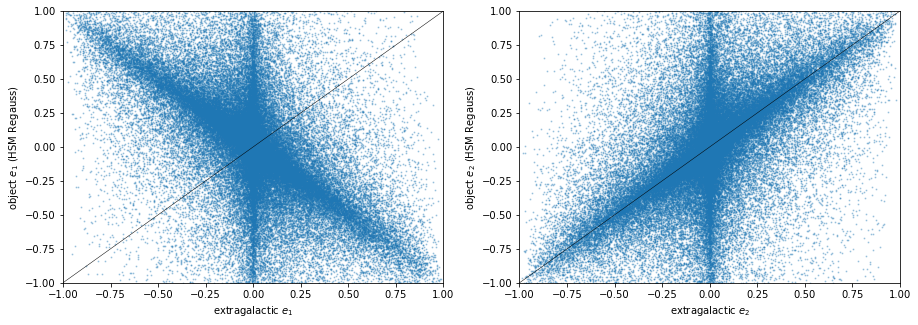

In [60]:
fig, axes = plt.subplots(1,2, figsize=(15,5));
axes[0].scatter(ellipticity_conversion(truth_data['ellipticity_1_true'][truth_idx[:100000]]), object_data['ext_shapeHSM_HsmShapeRegauss_e1'][object_idx[:100000]], s=1, alpha = 0.3);
lims = [-1, 1]
axes[0].plot(lims, lims, c='k', lw=0.5);
axes[0].set_xlabel('extragalactic $e_1$');
axes[0].set_ylabel('object $e_1$ (HSM Regauss)');
axes[0].set_xlim(lims);
axes[0].set_ylim(lims);


axes[1].scatter(ellipticity_conversion(truth_data['ellipticity_2_true'][truth_idx[:100000]]), object_data['ext_shapeHSM_HsmShapeRegauss_e2'][object_idx[:100000]], s=1, alpha = 0.3);
lims = [-1, 1]
axes[1].plot(lims, lims, c='k', lw=0.5);
axes[1].set_xlabel('extragalactic $e_2$');
axes[1].set_ylabel('object $e_2$ (HSM Regauss)');
axes[1].set_xlim(lims);
axes[1].set_ylim(lims);

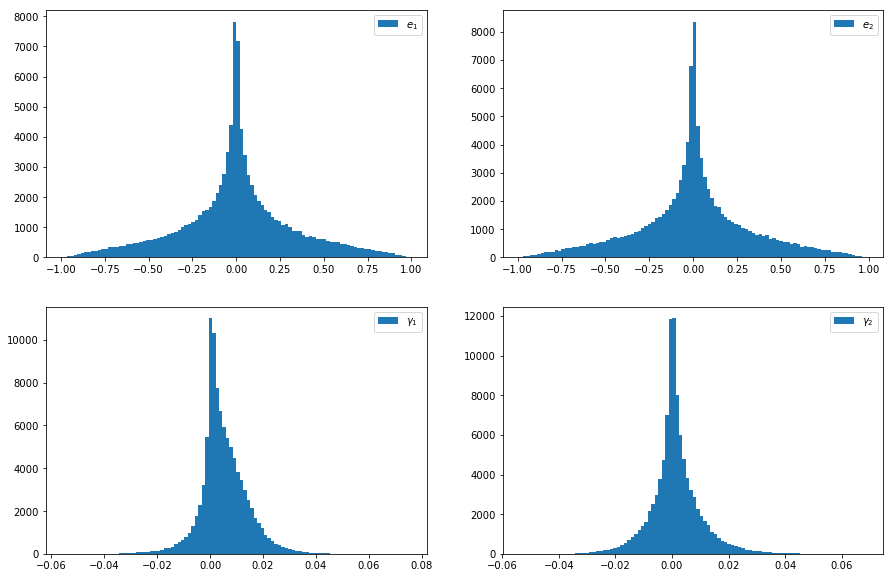

In [50]:
fig, axes = plt.subplots(2,2, figsize=(15,10))
_ = axes[0,0].hist(ellipticity_conversion(truth_data['ellipticity_1_true'][truth_idx[:100000]]), bins = 100, label = '$e_1$')
_ = axes[0,1].hist(ellipticity_conversion(truth_data['ellipticity_2_true'][truth_idx[:100000]]), bins = 100, label = '$e_2$')
_ = axes[1,0].hist(ellipticity_conversion(truth_data['shear_1'][truth_idx[:100000]]), bins = 100, label = '$\gamma_1$')
_ = axes[1,1].hist(ellipticity_conversion(truth_data['shear_2'][truth_idx[:100000]]), bins = 100, label = '$\gamma_2$')

axes[0,0].legend()
axes[0,1].legend()
axes[1,0].legend()
axes[1,1].legend()

Applying the same transofmration including convergence as for total ellipticity

In [62]:
def calc_lensed_ellipticity_1(es1, es2, gamma1, gamma2, kappa):
    gamma = gamma1 + gamma2*1j # shear (as a complex number)
    es =  es1 + es2*1j # intrinsic ellipticity (as a complex number)
    g = gamma / (1.0 - kappa) # reduced shear
    e = (es + g) / (1.0 + g.conjugate()*es) # lensed ellipticity
    return np.real(e)

def calc_lensed_ellipticity_2(es1, es2, gamma1, gamma2, kappa):
    gamma = gamma1 + gamma2*1j # shear (as a complex number)
    es =   es1 + es2*1j # intrinsic ellipticity (as a complex number)
    g = gamma / (1.0 - kappa) # reduced shear
    e = (es + g) / (1.0 + g.conjugate()*es) # lensed ellipticity
    return np.imag(e)

In [63]:
gc.add_derived_quantity('ellipticity_1', calc_lensed_ellipticity_1, 
                                       'ellipticity_1_true', 'ellipticity_2_true', 'shear_1', 'shear_2', 'convergence')

gc.add_derived_quantity('ellipticity_2', calc_lensed_ellipticity_2, 
                                       'ellipticity_1_true', 'ellipticity_2_true', 'shear_1', 'shear_2', 'convergence')

ValueError: quantity name `ellipticity_1` already exists

In [82]:
quantities = ['galaxy_id', 'ra', 'dec', 
              'mag_r', 'mag_r_lsst',
              'redshift',
              'ellipticity_true', 'convergence',
              'ellipticity_1_true', 'ellipticity_2_true',
              'ellipticity',
              'ellipticity_1', 'ellipticity_2',
              'morphology/totalEllipticity1' , 'morphology/totalEllipticity2' ,
              'shear_1', 'shear_2']
truth_data = gc.get_quantities(quantities, filters=truth_mag_filters+pos_filters, 
                                      native_filters=native_filter)

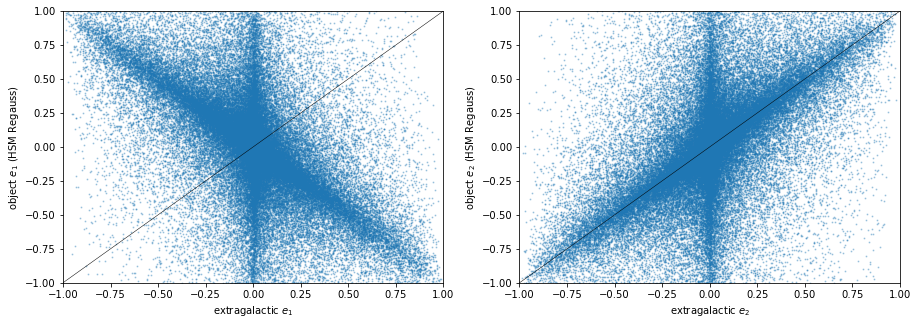

In [65]:
fig, axes = plt.subplots(1,2, figsize=(15,5));
axes[0].scatter(ellipticity_conversion(truth_data['ellipticity_1'][truth_idx[:100000]]), object_data['ext_shapeHSM_HsmShapeRegauss_e1'][object_idx[:100000]], s=1, alpha = 0.3);
lims = [-1, 1]
axes[0].plot(lims, lims, c='k', lw=0.5);
axes[0].set_xlabel('extragalactic $e_1$');
axes[0].set_ylabel('object $e_1$ (HSM Regauss)');
axes[0].set_xlim(lims);
axes[0].set_ylim(lims);


axes[1].scatter(ellipticity_conversion(truth_data['ellipticity_2'][truth_idx[:100000]]), object_data['ext_shapeHSM_HsmShapeRegauss_e2'][object_idx[:100000]], s=1, alpha = 0.3);
lims = [-1, 1]
axes[1].plot(lims, lims, c='k', lw=0.5);
axes[1].set_xlabel('extragalactic $e_2$');
axes[1].set_ylabel('object $e_2$ (HSM Regauss)');
axes[1].set_xlim(lims);
axes[1].set_ylim(lims);

Weird, it seems that the true $e_1$ has a sign inversion (confirmed on images).

<img src="imgs/shear_transformation.png" alt="Drawing" style="width: 400px;"/>

If I change the sign:

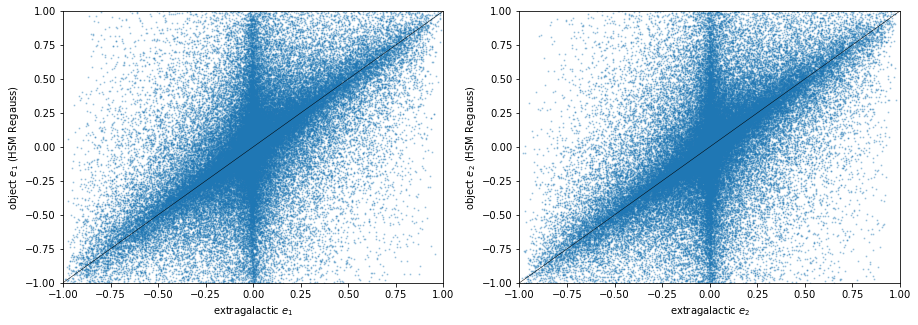

In [66]:
fig, axes = plt.subplots(1,2, figsize=(15,5));
axes[0].scatter(ellipticity_conversion(-truth_data['ellipticity_1'][truth_idx[:100000]]), object_data['ext_shapeHSM_HsmShapeRegauss_e1'][object_idx[:100000]], s=1, alpha = 0.3);
lims = [-1, 1]
axes[0].plot(lims, lims, c='k', lw=0.5);
axes[0].set_xlabel('extragalactic $e_1$');
axes[0].set_ylabel('object $e_1$ (HSM Regauss)');
axes[0].set_xlim(lims);
axes[0].set_ylim(lims);


axes[1].scatter(ellipticity_conversion(truth_data['ellipticity_2'][truth_idx[:100000]]), object_data['ext_shapeHSM_HsmShapeRegauss_e2'][object_idx[:100000]], s=1, alpha = 0.3);
lims = [-1, 1]
axes[1].plot(lims, lims, c='k', lw=0.5);
axes[1].set_xlabel('extragalactic $e_2$');
axes[1].set_ylabel('object $e_2$ (HSM Regauss)');
axes[1].set_xlim(lims);
axes[1].set_ylim(lims);

Check if ellipticity measurment other than ReGauss exists: No

In [109]:
def calc_lensed_ellipticity(es1, es2, gamma1, gamma2, kappa):
    gamma = gamma1 + gamma2*1j # shear (as a complex number)
    es =  es1 + es2*1j # intrinsic ellipticity (as a complex number)
    g = gamma / (1.0 - kappa) # reduced shear
    e = (es + g) / (1.0 + g.conjugate()*es) # lensed ellipticity
    return np.absolute(e)

In [110]:
ellipticity_conversion_im = lambda e: 2*e / (1.0+e*e.conjugate())

In [111]:
e = calc_lensed_ellipticity(truth_data['ellipticity_1_true'], truth_data['ellipticity_2_true'], truth_data['shear_1'], truth_data['shear_2'], truth_data['convergence'])

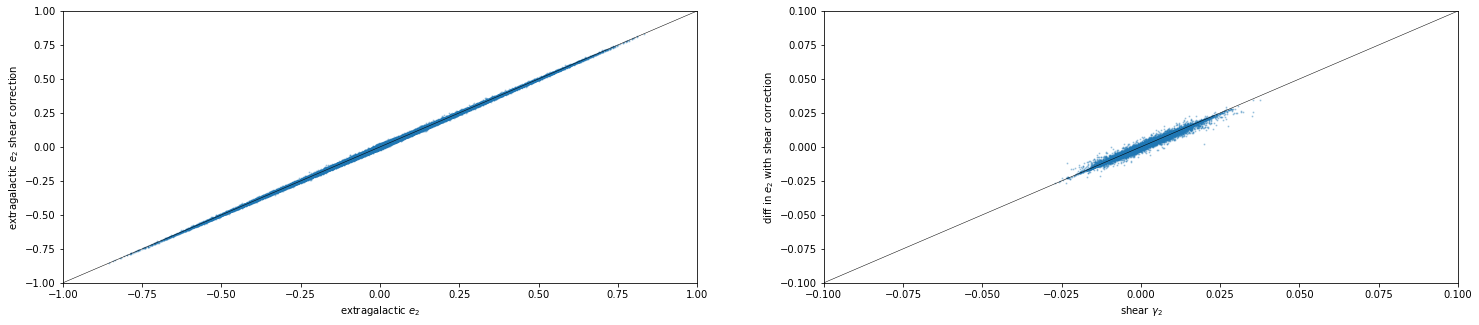

In [106]:
fig, axes = plt.subplots(1,2, figsize=(25,5));
axes[0].scatter(truth_data['ellipticity_2_true'][truth_idx[:100000]], truth_data['ellipticity_2'][truth_idx[:100000]], s=1, alpha = 0.3);
lims = [-1, 1]
axes[0].plot(lims, lims, c='k', lw=0.5);
axes[0].set_xlabel('extragalactic $e_2$');
axes[0].set_ylabel('extragalactic $e_2$ shear correction');
axes[0].set_xlim(lims);
axes[0].set_ylim(lims);

diff_2 = truth_data['ellipticity_2'][truth_idx[:100000]] - truth_data['ellipticity_2_true'][truth_idx[:100000]]#ellipticity_conversion(truth_data['ellipticity_2_true'][truth_idx[:100000]])
axes[1].scatter(diff_2, truth_data['shear_2'][truth_idx[:100000]], s=1,alpha = 0.3);
lims = [-0.1, 0.1]
axes[1].plot(lims, lims, c='k', lw=0.5);
axes[1].set_xlabel('shear $\gamma_2$');
axes[1].set_ylabel('diff in $e_2$ with shear correction');
axes[1].set_xlim(lims);
axes[1].set_ylim(lims);


The conversion going from $e_1$ (respectively $e_2$) HSM to $e_1$ (respectively $e_2$) true should not follow exactly the same transformation as for $e$. It should wollow $e_{1_{hsm}}=(2/(1+e^2))e_{1_{true}}$ since $(2/(1+e^2)) = e_{HSM}/e_{true} = (1-q)/(1+q) = e_{1_{hsm}}/e_{1_{true}}$.

$e_{1_{hsm}} = (1-q)^2/(1+q)^2*cos(2\phi)$       and         $e_{1_{true}} = (1-q)/(1+q)*cos(2\phi)$ 

### Check other distributions

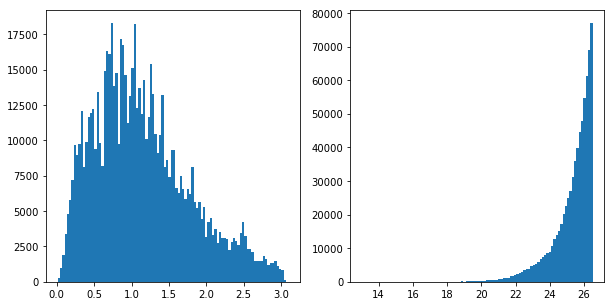

In [48]:
fig, axes = plt.subplots(1,2, figsize = (10,5))
_ = axes[0].hist(truth_data['redshift'], bins = 100)
_ = axes[1].hist(truth_data['mag_r'], bins = 100)

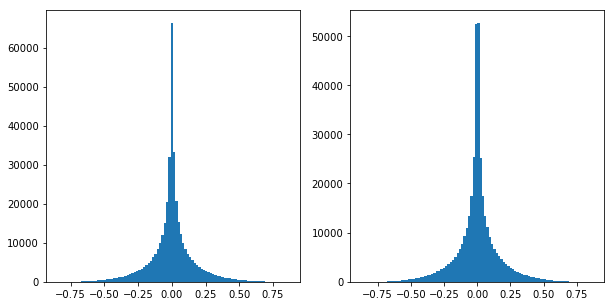

In [50]:
fig, axes = plt.subplots(1,2, figsize = (10,5))
_ = axes[0].hist(truth_data['ellipticity_1_true'][truth_idx], bins = 100)
_ = axes[1].hist(truth_data['ellipticity_2_true'][truth_idx], bins = 100)

Text(0, 0.5, '$r$-magnitude')

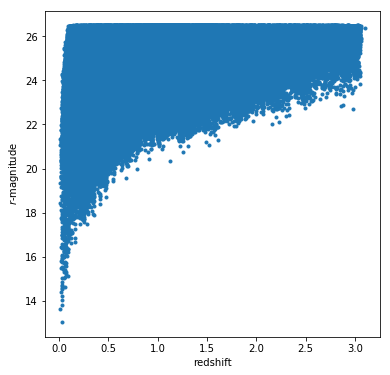

In [51]:
plt.plot(truth_data['redshift'], truth_data['mag_r'], '.')
plt.xlabel('redshift')
plt.ylabel('$r$-magnitude')

### Check img + ellipse fitted with ellipticity true values

As a function of the sign of $e_1$, width and height are inverted.

596168 13


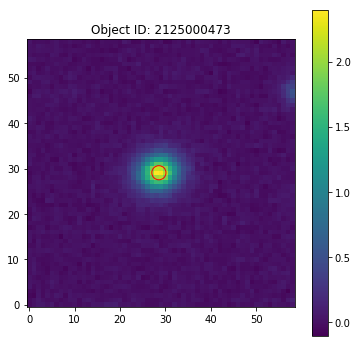

In [52]:
# Plot just one
i = 10
first = id_ra_dec[object_idx[i]]
print(object_idx[i], truth_idx[i])
ra, dec = first['ra'], first['dec']
frame = 0
plt.figure(frame)

cutout = cutout_img_dc2.make_cutout_image(butler, ra, dec, filter='r', label="Object ID: %d" % truth_data['galaxy_id'][truth_idx[i]])

e1 true: -0.09969687239698169
e2 true: 0.05080216661964432
shear_1 true: -1.3997631268414246e-05
shear_2 true: 4.231821281933749e-05
redshift true: 0.03861878519130468
13.50092911456568 0.49868190794939565


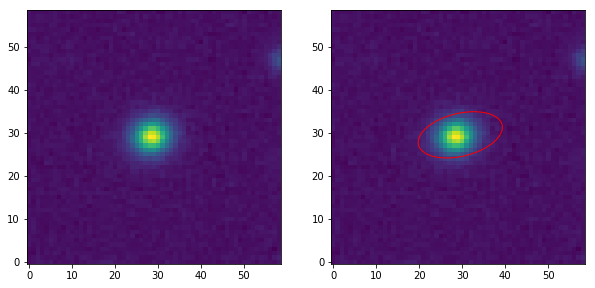

In [53]:
img_array = cutout.image.array
print('e1 true: '+str(truth_data['ellipticity_1_true'][truth_idx[i]]))
print('e2 true: '+str(truth_data['ellipticity_2_true'][truth_idx[i]]))
print('shear_1 true: '+str(truth_data['shear_1'][truth_idx[i]]))
print('shear_2 true: '+str(truth_data['shear_2'][truth_idx[i]]))
print('redshift true: '+str(truth_data['redshift'][truth_idx[i]]))

fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].imshow(img_array, origin='lower')
#ax[0].colorbar()

phi = np.arctan(truth_data['ellipticity_2_true'][truth_idx[i]]/-truth_data['ellipticity_1_true'][truth_idx[i]])/2
hypot = np.hypot(truth_data['ellipticity_1_true'][truth_idx[i]], truth_data['ellipticity_2_true'][truth_idx[i]])
q = (1-np.sqrt(hypot))/(1+np.sqrt(hypot))
print(phi*180/np.pi, q)
width = 20
if (truth_data['ellipticity_1_true'][truth_idx[i]]>0):
    ell_patch = matplotlib.patches.Ellipse((len(img_array)/2,len(img_array)/2), width*q, width, angle=phi*180/np.pi, edgecolor = 'red', fill = False)
else:
    ell_patch = matplotlib.patches.Ellipse((len(img_array)/2,len(img_array)/2), width, width*q, angle=phi*180/np.pi, edgecolor = 'red', fill = False)   

ax[1].imshow(img_array, origin='lower')
ax[1].add_patch(ell_patch)

520648 20


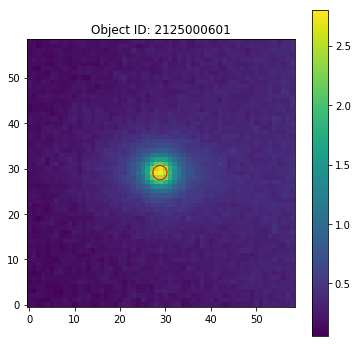

In [54]:
# Plot just one
i = 17
first = id_ra_dec[object_idx[i]]
print(object_idx[i], truth_idx[i])
ra, dec = first['ra'], first['dec']
frame = 0
plt.figure(frame)

cutout = cutout_img_dc2.make_cutout_image(butler, ra, dec, filter='r', label="Object ID: %d" % truth_data['galaxy_id'][truth_idx[i]])

e1 true: -0.17854626126747486
e2 true: -0.03397228528432375
shear_1 true: -1.4186877369870565e-05
shear_2 true: 0.00022897177458736106
redshift true: 0.07107975244389064


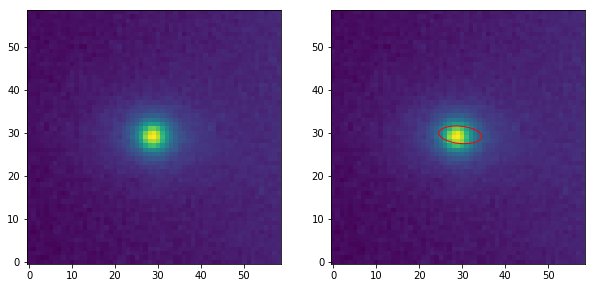

In [55]:
img_array = cutout.image.array
print('e1 true: '+str(truth_data['ellipticity_1_true'][truth_idx[i]]))
print('e2 true: '+str(truth_data['ellipticity_2_true'][truth_idx[i]]))
print('shear_1 true: '+str(truth_data['shear_1'][truth_idx[i]]))
print('shear_2 true: '+str(truth_data['shear_2'][truth_idx[i]]))
print('redshift true: '+str(truth_data['redshift'][truth_idx[i]]))

fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].imshow(img_array, origin='lower')

phi = np.arctan(truth_data['ellipticity_2_true'][truth_idx[i]]/-truth_data['ellipticity_1_true'][truth_idx[i]])/2
hypot = np.hypot(-truth_data['ellipticity_1_true'][truth_idx[i]], truth_data['ellipticity_2_true'][truth_idx[i]])
q = (1-np.sqrt(hypot))/(1+np.sqrt(hypot))

width = 10
if (truth_data['ellipticity_1_true'][truth_idx[i]]>0):
    ell_patch = matplotlib.patches.Ellipse((len(img_array)/2,len(img_array)/2), width*q, width, angle=phi*180/np.pi, edgecolor = 'red', fill = False)
else:
    ell_patch = matplotlib.patches.Ellipse((len(img_array)/2,len(img_array)/2), width, width*q, angle=phi*180/np.pi, edgecolor = 'red', fill = False)   

ax[1].imshow(img_array, origin='lower')
ax[1].add_patch(ell_patch)

516229 18


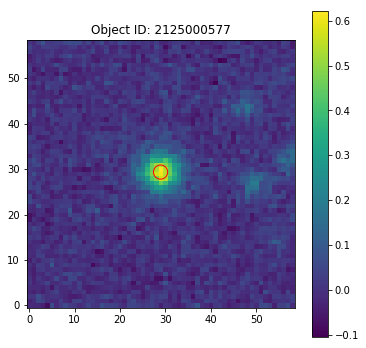

In [56]:
# Plot just one
i = 15
first = id_ra_dec[object_idx[i]]
print(object_idx[i], truth_idx[i])
ra, dec = first['ra'], first['dec']
frame = 0
plt.figure(frame)

cutout = cutout_img_dc2.make_cutout_image(butler, ra, dec, filter='r', label="Object ID: %d" % truth_data['galaxy_id'][truth_idx[i]])

e1 true: 0.011451132336940874
e2 true: -0.044219824223313275
shear_1 true: 9.8891019975067e-06
shear_2 true: 5.756351322363474e-05
redshift true: 0.04623058643327749
37.74082648022916 0.6478194751980006


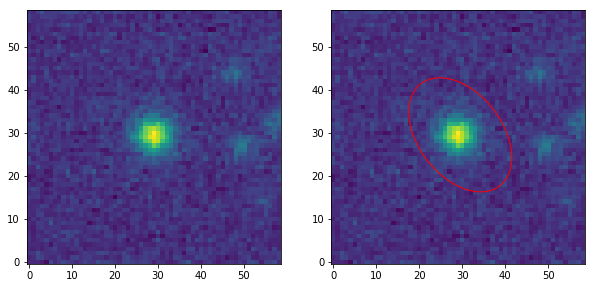

In [57]:
img_array = cutout.image.array
print('e1 true: '+str(truth_data['ellipticity_1_true'][truth_idx[i]]))
print('e2 true: '+str(truth_data['ellipticity_2_true'][truth_idx[i]]))
print('shear_1 true: '+str(truth_data['shear_1'][truth_idx[i]]))
print('shear_2 true: '+str(truth_data['shear_2'][truth_idx[i]]))
print('redshift true: '+str(truth_data['redshift'][truth_idx[i]]))

fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].imshow(img_array, origin='lower')

phi = np.arctan(truth_data['ellipticity_2_true'][truth_idx[i]]/-truth_data['ellipticity_1_true'][truth_idx[i]])/2
hypot = np.hypot(truth_data['ellipticity_1_true'][truth_idx[i]], truth_data['ellipticity_2_true'][truth_idx[i]])
q = (1-np.sqrt(hypot))/(1+np.sqrt(hypot))

print(phi*180/np.pi, q)
width = 30
if (truth_data['ellipticity_1_true'][truth_idx[i]]>0):
    ell_patch = matplotlib.patches.Ellipse((len(img_array)/2,len(img_array)/2), width*q, width, angle=phi*180/np.pi, edgecolor = 'red', fill = False)
else:
    ell_patch = matplotlib.patches.Ellipse((len(img_array)/2,len(img_array)/2), width, width*q, angle=phi*180/np.pi, edgecolor = 'red', fill = False)   

ax[1].imshow(img_array, origin='lower')
ax[1].add_patch(ell_patch)

Ellipse is completly off for true value. What about with corrected values ? 

e1 true: 0.011451132336940874
e2 true: -0.044219824223313275
shear_1 true: 9.8891019975067e-06
shear_2 true: 5.756351322363474e-05
redshift true: 0.04623058643327749
e1 obs: 0.011461097632624338
e2 obs: -0.04416235615754602


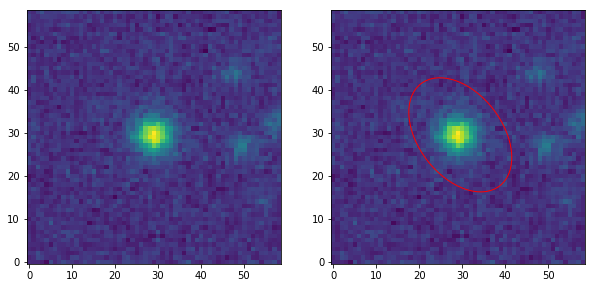

In [58]:
img_array = cutout.image.array
print('e1 true: '+str(truth_data['ellipticity_1_true'][truth_idx[i]]))
print('e2 true: '+str(truth_data['ellipticity_2_true'][truth_idx[i]]))
print('shear_1 true: '+str(truth_data['shear_1'][truth_idx[i]]))
print('shear_2 true: '+str(truth_data['shear_2'][truth_idx[i]]))
print('redshift true: '+str(truth_data['redshift'][truth_idx[i]]))

print('e1 obs: '+str(truth_data['ellipticity_1'][truth_idx[i]]))
print('e2 obs: '+str(truth_data['ellipticity_2'][truth_idx[i]]))

fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].imshow(img_array, origin='lower')

phi = np.arctan(truth_data['ellipticity_2'][truth_idx[i]]/-truth_data['ellipticity_1'][truth_idx[i]])/2
hypot = np.hypot(-truth_data['ellipticity_1'][truth_idx[i]], truth_data['ellipticity_2'][truth_idx[i]])
q = (1-np.sqrt(hypot))/(1+np.sqrt(hypot))

width = 30
if (truth_data['ellipticity_1_true'][truth_idx[i]]>0):
    ell_patch = matplotlib.patches.Ellipse((len(img_array)/2,len(img_array)/2), width*q, width, angle=phi*180/np.pi, edgecolor = 'red', fill = False)
else:
    ell_patch = matplotlib.patches.Ellipse((len(img_array)/2,len(img_array)/2), width, width*q, angle=phi*180/np.pi, edgecolor = 'red', fill = False)   

ax[1].imshow(img_array, origin='lower')
ax[1].add_patch(ell_patch)

 And with observed values ? 

e1 true: 0.011451132336940874
e2 true: -0.044219824223313275
shear_1 true: 9.8891019975067e-06
shear_2 true: 5.756351322363474e-05
redshift true: 0.04623058643327749
e1 obs: -0.07054141163825989
e2 obs: -0.12767744064331055


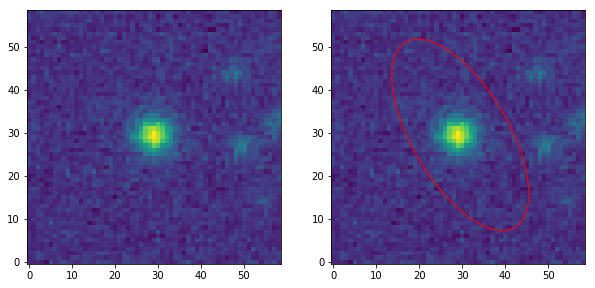

In [59]:
img_array = cutout.image.array
print('e1 true: '+str(truth_data['ellipticity_1_true'][truth_idx[i]]))
print('e2 true: '+str(truth_data['ellipticity_2_true'][truth_idx[i]]))
print('shear_1 true: '+str(truth_data['shear_1'][truth_idx[i]]))
print('shear_2 true: '+str(truth_data['shear_2'][truth_idx[i]]))
print('redshift true: '+str(truth_data['redshift'][truth_idx[i]]))

print('e1 obs: '+str(object_data['ext_shapeHSM_HsmShapeRegauss_e1'][object_idx[i]]))
print('e2 obs: '+str(object_data['ext_shapeHSM_HsmShapeRegauss_e2'][object_idx[i]]))

fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].imshow(img_array, origin='lower')

phi = np.arctan(object_data['ext_shapeHSM_HsmShapeRegauss_e2'][object_idx[i]]/object_data['ext_shapeHSM_HsmShapeRegauss_e1'][object_idx[i]])/2
hypot = np.hypot(object_data['ext_shapeHSM_HsmShapeRegauss_e1'][object_idx[i]], object_data['ext_shapeHSM_HsmShapeRegauss_e2'][object_idx[i]])
q = (1-np.sqrt(hypot))/(1+np.sqrt(hypot))

width = 50

if (truth_data['ellipticity_1_true'][truth_idx[i]]>0):
    ell_patch = matplotlib.patches.Ellipse((len(img_array)/2,len(img_array)/2), width*q, width, angle=phi*180/np.pi, edgecolor = 'red', fill = False)
else:
    ell_patch = matplotlib.patches.Ellipse((len(img_array)/2,len(img_array)/2), width, width*q, angle=phi*180/np.pi, edgecolor = 'red', fill = False)   

ax[1].imshow(img_array, origin='lower')
ax[1].add_patch(ell_patch)

# Add PSF image

## Generate PSF images

The cutout image object retains full information from the image, including the PSF model.

The PSF model is accessible as a function object that can be evaluated a specific locations.

In addition, the coadd catalog saves the xx, xy, yy moments of the PSF model at the location of photometered objects.

In [60]:
# We still have our cutout image object from above
psf = cutout.getPsf()

In [61]:
print(psf)

In [62]:
help(psf)

Help on CoaddPsf in module lsst.meas.algorithms.coaddPsf.coaddPsf object:

class CoaddPsf(PersistableFacadeCoaddPsf, lsst.meas.algorithms.imagePsf.ImagePsf)
 |  Method resolution order:
 |      CoaddPsf
 |      PersistableFacadeCoaddPsf
 |      lsst.meas.algorithms.imagePsf.ImagePsf
 |      lsst.meas.algorithms.imagePsf.PersistableFacadeImagePsf
 |      lsst.afw.detection.Psf
 |      lsst.afw.typehandling.Storable
 |      lsst.afw.table.io.Persistable
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __init__(self: lsst.meas.algorithms.coaddPsf.coaddPsf.CoaddPsf, catalog: lsst.afw.table.ExposureCatalog, coaddWcs: lsst.afw.geom.skyWcs.skyWcs.SkyWcs, weightFieldName: str='weight', warpingKernelName: str='lanczos3', cacheSize: int=10000) -> None
 |      
 |      2. __init__(self: lsst.meas.algorithms.coaddPsf.coaddPsf.CoaddPsf, catalog: l

The repetition in the object name is a consequence of the pybind11 mapping.  It's really a `lsst.meas.algorithms.coaddPsf.CoaddPsf` object.  The C++ documentation unfortunately doesn't come through nicely through the wrapping to Python:

We can look up the documentation in the LSST DM Stack Doxygen pages.  If we assume (correctly for these purposes) that a CoaddPsf is just like a regular PSF, then we can look here:
http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/classlsst_1_1afw_1_1detection_1_1_psf.html

where we will see that there are several relevant functions:
`computeImage`: Return an Image of the PSF, in a form that can be compared directly with star images.
`computeKernelImage`:  Return an Image of the PSF, in a form suitable for convolution.
`computeShape`: Compute the ellipse corresponding to the second moments of the Psf.

and then some interesting things you might not have expected to even be available:
`getAverageColor`: Return the average Color of the stars used to construct the Psf.
`getAveragePosition`: Return the average position of the stars used to construct the Psf. 

Unfortunately, the documentation is hard to read from a Python perspective.  What kind of arguments does the following function actually want and how do I create those objects?

computeImage(...) from builtins.PyCapsule
        computeImage(self: lsst.afw.detection._psf.Psf, position: lsst.afw.geom.coordinates.coordinates.Point2D=Point2D(nan, nan), color: lsst.afw.image.color.Color=<lsst.afw.image.color.Color object at 0x2b8f57b38928>, owner: lsst.afw.detection._psf.ImageOwnerEnum=ImageOwnerEnum.COPY) -> lsst.afw.image.image.image.ImageD)

Examples are easiest:

In [63]:
# Let's use the same first row to get an RA, Dec and translate that to an x, y on the image plane.
i = 15
first = id_ra_dec[object_idx[i]]
print(object_idx[i], truth_idx[i])
ra, dec = first['ra'], first['dec']
radec = lsst.geom.SpherePoint(ra, dec, lsst.geom.degrees)
xy = cutout.getWcs().skyToPixel(radec)  # returns a Point2D

kernel_image = psf.computeImage(xy)

516229 18


In [64]:
psf.computeImage(xy).getDimensions

<bound method PyCapsule.getDimensions of lsst.afw.image.image.image.ImageD=[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], bbox=(minimum=(22053, 23822), maximum=(22111, 23880))>

In [65]:
psf.computeImage(xy).getDimensions()

Extent2I(59, 59)

In [66]:
psf.computeImage(xy).getX0()

22053

The object we get back is an `lsst.afw.image.image.ImageD` -- An `Image` in double precision.

Let's display the kernel image we made:

In [67]:
help(psf.computeImage)

Help on method computeImage in module lsst.afw.detection:

computeImage(...) method of lsst.meas.algorithms.coaddPsf.coaddPsf.CoaddPsf instance
    computeImage(self: lsst.afw.detection.Psf, position: lsst.geom.Point2D=Point2D(nan, nan), color: lsst.afw.image.color.Color=<lsst.afw.image.color.Color object at 0x7fb43fb1b470>, owner: lsst.afw.detection.Psf.ImageOwnerEnum=ImageOwnerEnum.???) -> lsst.afw.image.image.image.ImageD



In [68]:
kernel_image

lsst.afw.image.image.image.ImageD=[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], bbox=(minimum=(22053, 23822), maximum=(22111, 23880))

In [69]:
help(kernel_image)

Help on ImageD in module lsst.afw.image.image.image object:

class ImageD(ImageBaseD)
 |  Method resolution order:
 |      ImageD
 |      ImageBaseD
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  Factory(self, *args, **kwargs)
 |      Return an object of this type
 |  
 |  __add__ = notImplemented(self, other)
 |      Provide a helpful error message about image arithmetic
 |      
 |      Unless we're operating on an ImageSlice, in which case it might be
 |      defined.
 |      
 |      Parameters
 |      ----------
 |      self : subclass of `lsst.afw.image.ImageBase`
 |          Image someone's attempting to do arithmetic with.
 |      other : anything
 |          The operand of the arithmetic operation.
 |  
 |  __getitem__(self, imageSlice)
 |  
 |  __iadd__(...)
 |      __iadd__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __iadd__(self: lsst.afw.image.image.image.ImageD, arg0: float) -> lsst.afw.imag

For comparison, the postage stamp is a full `lsst.afw.image.exposure.ExposureF`.  An `Exposure` contains a `MaskedImage` (an image, a mask, and variance plane), along with an optional SkyWCS.
http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/classlsst_1_1afw_1_1image_1_1_exposure.html#details

An `Exposure` can also generate `subExposures`, which are `Exposure`s of a subset of the pixels.  Our postage stamp cutout is thus an `Exposure`.  The additional information is what allowed `afwDisplay` to show the image with the original pixel coordinates.

If you read a `raw`, `calexp`, or `deepCoadd` or similar image product through the Butler, you will get an `Exposure`.

In [70]:
help(cutout)

Help on ExposureF in module lsst.afw.image.exposure.exposure object:

class ExposureF(pybind11_builtins.pybind11_object)
 |  Method resolution order:
 |      ExposureF
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  Factory(self, *args, **kwargs)
 |      Return an object of this type
 |  
 |  __add__ = notImplemented(self, other)
 |      Provide a helpful error message about image arithmetic
 |      
 |      Unless we're operating on an ImageSlice, in which case it might be
 |      defined.
 |      
 |      Parameters
 |      ----------
 |      self : subclass of `lsst.afw.image.ImageBase`
 |          Image someone's attempting to do arithmetic with.
 |      other : anything
 |          The operand of the arithmetic operation.
 |  
 |  __getitem__(self, imageSlice)
 |  
 |  __init__(...)
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __init__(self: lsst.afw.image.exposure.exposure.ExposureF, w

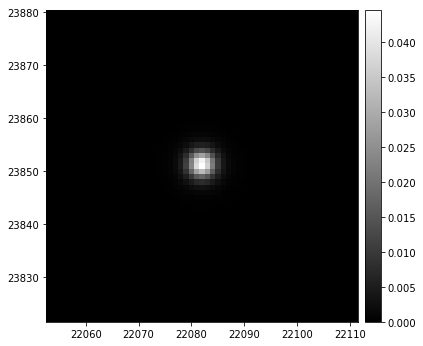

In [71]:
frame = 2
plt.figure(frame)
display = afwDisplay.Display(frame=frame, backend='matplotlib')
display.scale("linear", "minmax")
display.mtv(kernel_image)

(59, 59)

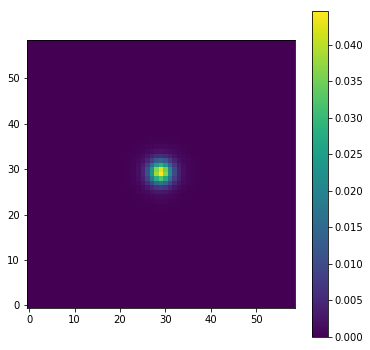

In [72]:
plt.imshow(kernel_image.array, origin = 'lower')
plt.colorbar()

kernel_image.array.shape

Above we see an image of the PSF centered at the x, y position corresponding to the RA, Dec position of the object.  This is a convenient representation to use to subtract.

Note that while the cutout was 51x51 pixels (the default `cutoutSideLength` in `cutout_coadd_spherepoint` above), the PSF is 59x59 pixels.  That's the default size of specifying the full PSF. You can actually have a 64x64 pixels cutout image modifying the `cutoutSideLength` in the `cutout_coadd_spherepoint` function

Try then to generate a PSF image suitable for convolution:

In [73]:
kernel_image_conv = psf.computeKernelImage(xy)

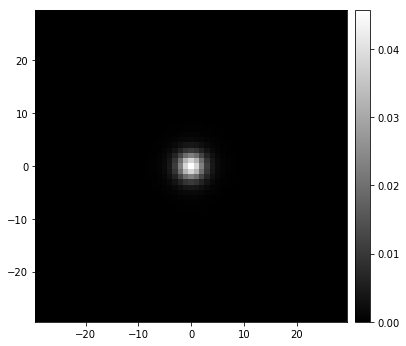

In [74]:
frame = 2
plt.figure(frame)
display = afwDisplay.Display(frame=frame, backend='matplotlib')
display.scale("linear", "minmax")
display.mtv(kernel_image_conv)

(59, 59)

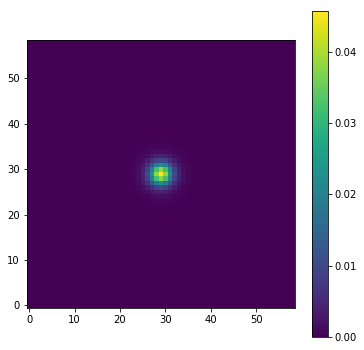

In [75]:
plt.imshow(kernel_image_conv.array, origin = 'lower')
plt.colorbar()

kernel_image_conv.array.shape

## Fix the cutout image to the PSF image size so I don't have to worry about rescaling

In [84]:
reload(cutout_img_dc2)

<module 'tools_for_VAE.cutout_img_dc2' from '../../scripts/tools_for_VAE/tools_for_VAE/cutout_img_dc2.py'>

Go to 59x59 pixels size for stamps

519782 19


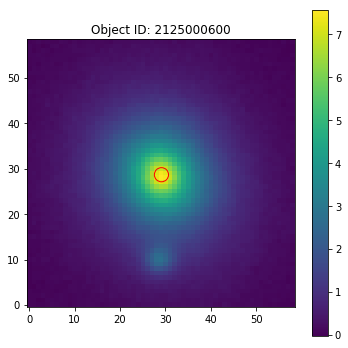

In [85]:
i = 16
first = id_ra_dec[object_idx[i]]
print(object_idx[i], truth_idx[i])
ra, dec = first['ra'], first['dec']
frame = 0
plt.figure(frame)

cutout = cutout_img_dc2.make_cutout_image(butler, ra, dec, filter='r', label="Object ID: %d" % truth_data['galaxy_id'][truth_idx[i]])

e1 true: 0.03590922526880659
e2 true: -0.050523586442690435
shear_1 true: -3.768900643141837e-05
shear_2 true: 0.00020382012379233588
redshift true: 0.07123882653582769


(59, 59)

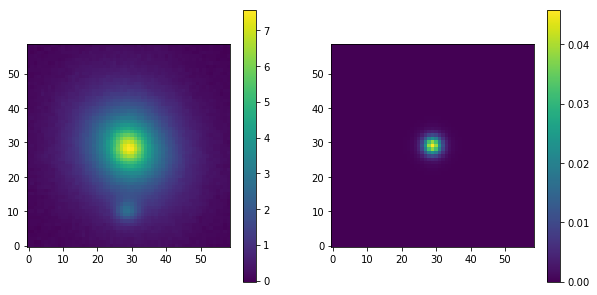

In [86]:
img_array = cutout.image.array
print('e1 true: '+str(truth_data['ellipticity_1_true'][truth_idx[i]]))
print('e2 true: '+str(truth_data['ellipticity_2_true'][truth_idx[i]]))
print('shear_1 true: '+str(truth_data['shear_1'][truth_idx[i]]))
print('shear_2 true: '+str(truth_data['shear_2'][truth_idx[i]]))
print('redshift true: '+str(truth_data['redshift'][truth_idx[i]]))

fig, ax = plt.subplots(1,2, figsize = (10,5))

fig_1 = ax[0].imshow(img_array, origin='lower')

phi = np.arctan(object_data['ext_shapeHSM_HsmShapeRegauss_e2'][object_idx[i]]/object_data['ext_shapeHSM_HsmShapeRegauss_e1'][object_idx[i]])/2
hypot = np.hypot(object_data['ext_shapeHSM_HsmShapeRegauss_e1'][object_idx[i]], object_data['ext_shapeHSM_HsmShapeRegauss_e2'][object_idx[i]])
q = (1-np.sqrt(hypot))/(1+np.sqrt(hypot))

width = 50

if (truth_data['ellipticity_1_true'][truth_idx[i]]>0):
    ell_patch = matplotlib.patches.Ellipse((32,32), width*q, width, angle=phi*180/np.pi, edgecolor = 'red', fill = False)
else:
    ell_patch = matplotlib.patches.Ellipse((32,32), width, width*q, angle=phi*180/np.pi, edgecolor = 'red', fill = False)   

fig_2 = ax[1].imshow(kernel_image_conv.array, origin = 'lower')

fig.colorbar(fig_1 ,ax=ax[0])
fig.colorbar(fig_2 ,ax=ax[1])

kernel_image_conv.array.shape

# Generate multi-bands images of scenes and PSF

## Visualize different filters

Image in $r$ filter

519782 19


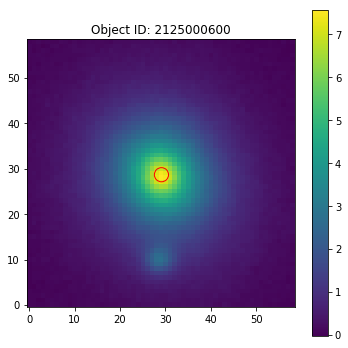

In [87]:
i = 16
first = id_ra_dec[object_idx[i]]
print(object_idx[i], truth_idx[i])
ra, dec = first['ra'], first['dec']
frame = 0
plt.figure(frame)

cutout_r = cutout_img_dc2.make_cutout_image(butler, ra, dec, filter='r', label="Object ID: %d" % truth_data['galaxy_id'][truth_idx[i]])

Image in $i$ filter

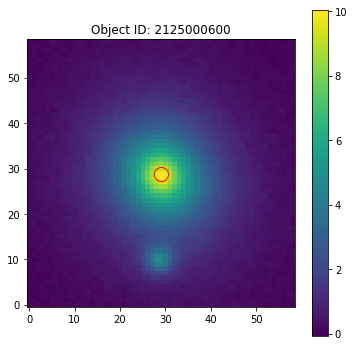

In [88]:
frame = 0
plt.figure(frame)

cutout_i = cutout_img_dc2.make_cutout_image(butler, ra, dec, filter='i', label="Object ID: %d" % truth_data['galaxy_id'][truth_idx[i]])

Image in $z$ filter

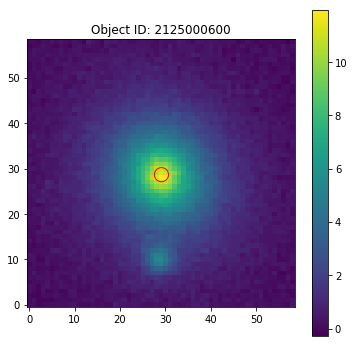

In [89]:
frame = 0
plt.figure(frame)

cutout_z = cutout_img_dc2.make_cutout_image(butler, ra, dec, filter='z', label="Object ID: %d" % truth_data['galaxy_id'][truth_idx[i]])

Plot in rgb (here $r,i,z$)

In [91]:
# galaxies scene image
gal = np.zeros((3, 59,59))

gal[0] = cutout_r.image.array
gal[1] = cutout_i.image.array
gal[2] = cutout_z.image.array

# Normalize between [0,1] for display reasons only
gal -= np.min(gal)
gal /= np.max(gal)

# Necessary for PSF position
radec = lsst.geom.SpherePoint(ra, dec, lsst.geom.degrees)
xy = cutout.getWcs().skyToPixel(radec)  # returns a Point2D

# Create PSF image
psf_img = np.zeros((3, 59,59))
psf_img[0] = cutout_r.getPsf().computeKernelImage(xy).array
psf_img[1] = cutout_i.getPsf().computeKernelImage(xy).array
psf_img[2] = cutout_z.getPsf().computeKernelImage(xy).array

# Normalize between [0,1] for display reasons only
psf_img -= np.min(psf_img)
psf_img /= np.max(psf_img)

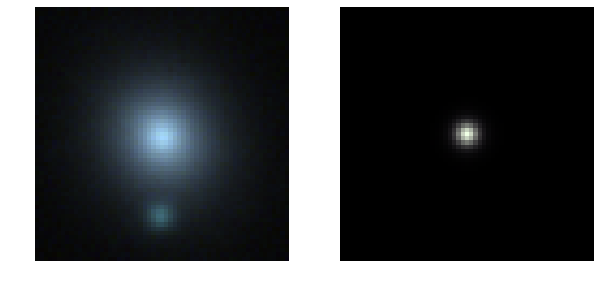

In [92]:
fig, axes  = plt.subplots(1,2, figsize = (10,5))

plot.plot_rgb(gal, bands=[0,1,2], ax=axes[0], band_first=True, zoom=1)
plot.plot_rgb(psf_img, bands=[0,1,2], ax=axes[1], band_first=True, zoom=1)

$u$ filter does not work as the butler is created from a catalog containing only $g,r,i,z,y$. To create the $u$ filter we will have to define a new butler

In [ ]:
frame = 0
plt.figure(frame)

cutout_u = cutout_img_dc2.make_cutout_image(butler, ra, dec, filter='u', label="Object ID: %d" % truth_data['galaxy_id'][truth_idx[i]])

Defining the new butler:

In [93]:
repo = '/sps/lssttest/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1-u'
butler_u = dafPersist.Butler(repo)

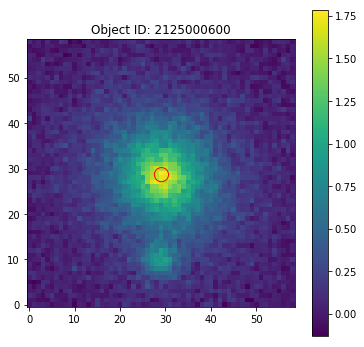

In [94]:
frame = 0
plt.figure(frame)

cutout_u = cutout_img_dc2.make_cutout_image(butler_u, ra, dec, filter='u', label="Object ID: %d" % truth_data['galaxy_id'][truth_idx[i]])

## Generate samples for networks

In [95]:
import time

In [96]:
print('e1 true: '+str(truth_data['ellipticity_1_true'][truth_idx[i]]))
print('e2 true: '+str(truth_data['ellipticity_2_true'][truth_idx[i]]))
print('shear_1 true: '+str(truth_data['shear_1'][truth_idx[i]]))
print('shear_2 true: '+str(truth_data['shear_2'][truth_idx[i]]))
print('redshift true: '+str(truth_data['redshift'][truth_idx[i]]))

e1 true: 0.03590922526880659
e2 true: -0.050523586442690435
shear_1 true: -3.768900643141837e-05
shear_2 true: 0.00020382012379233588
redshift true: 0.07123882653582769


0


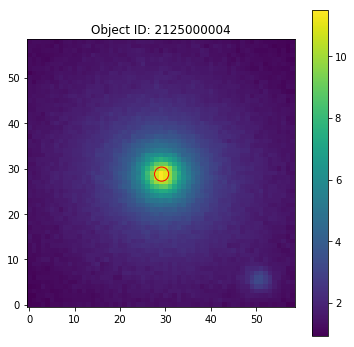

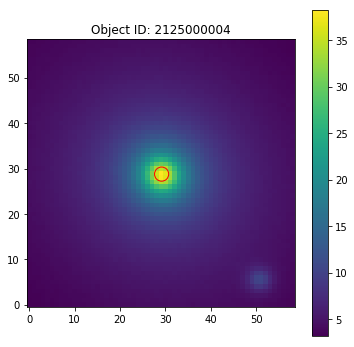

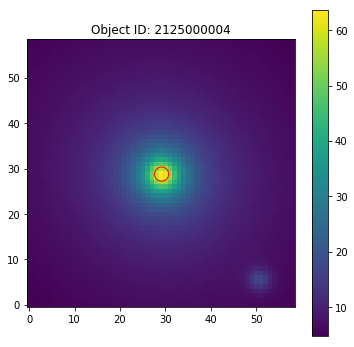

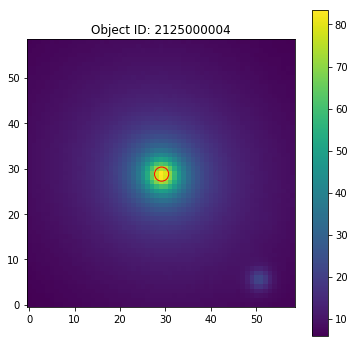

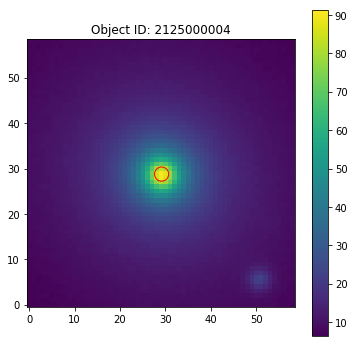

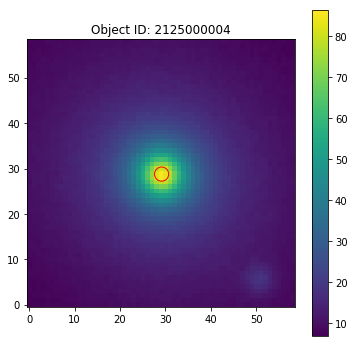

1


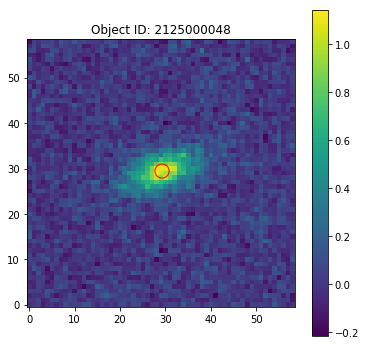

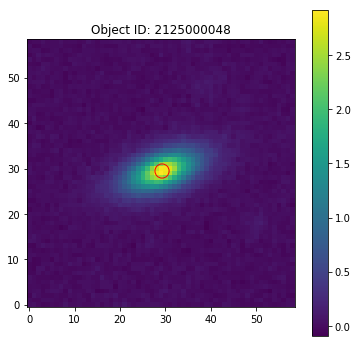

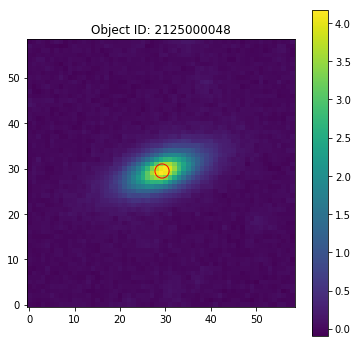

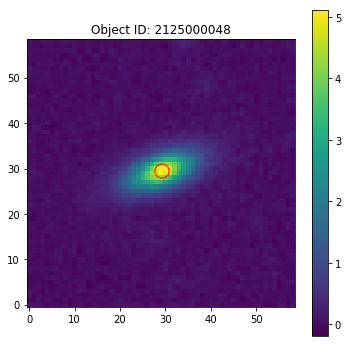

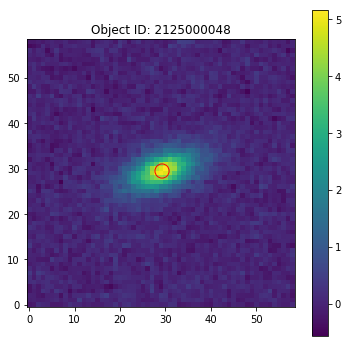

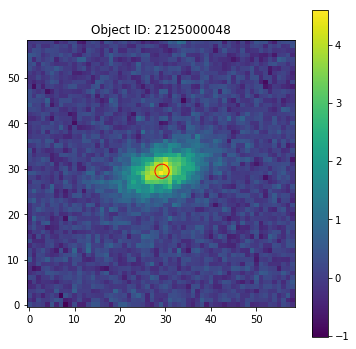

2


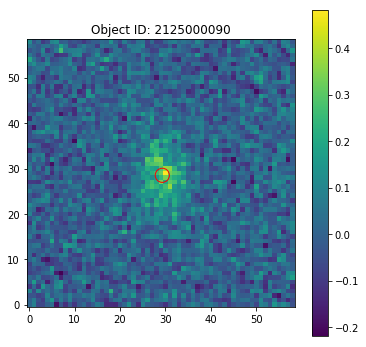

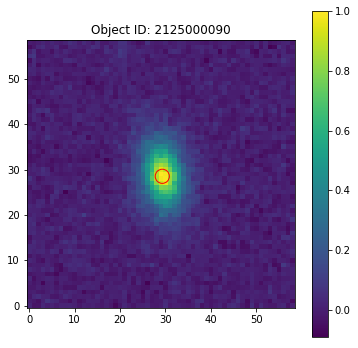

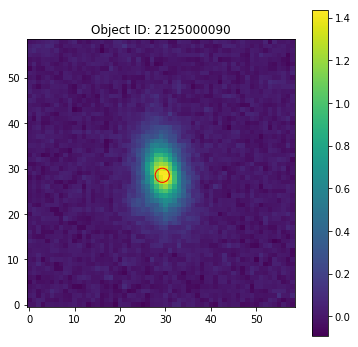

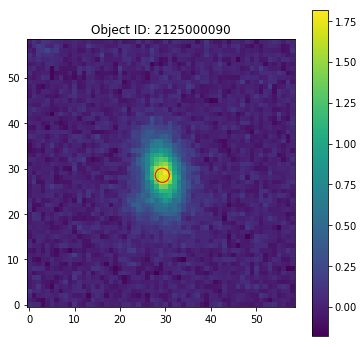

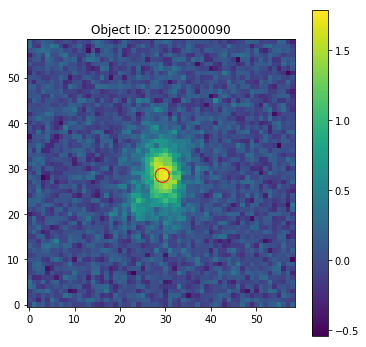

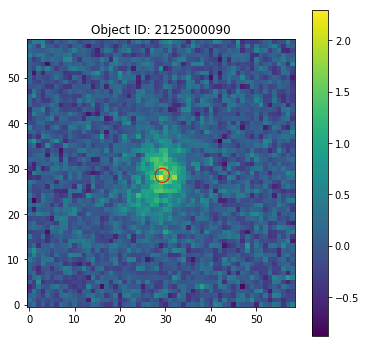

3


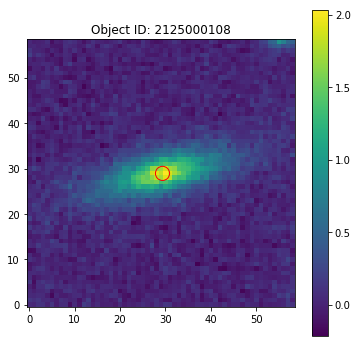

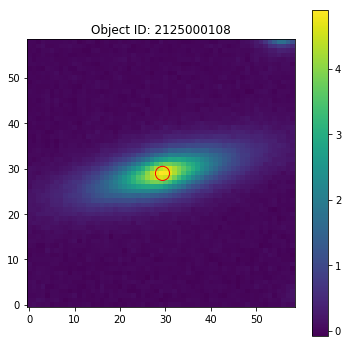

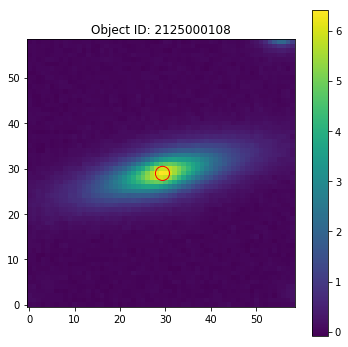

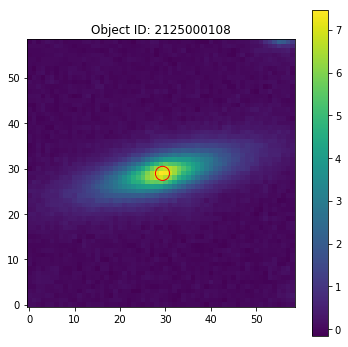

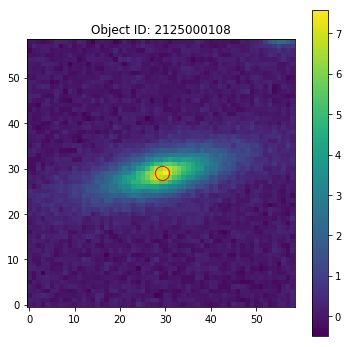

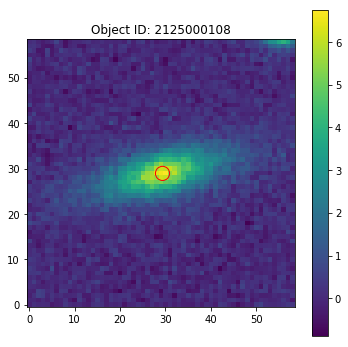

4


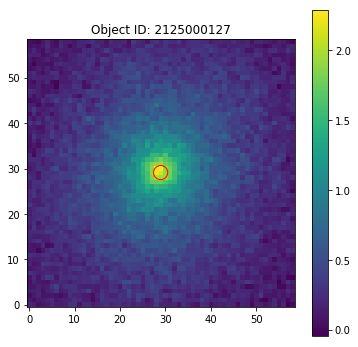

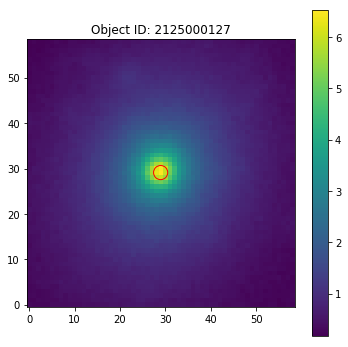

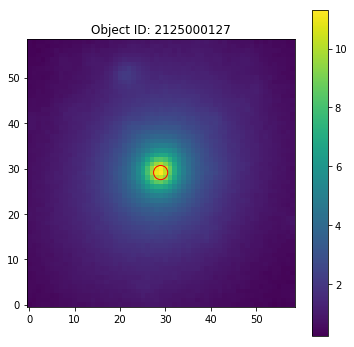

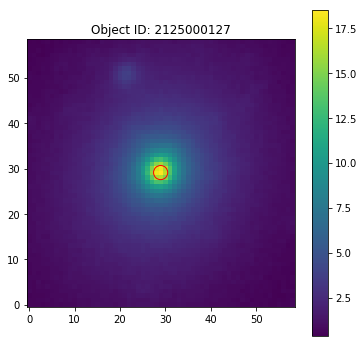

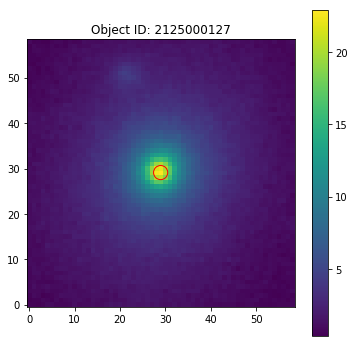

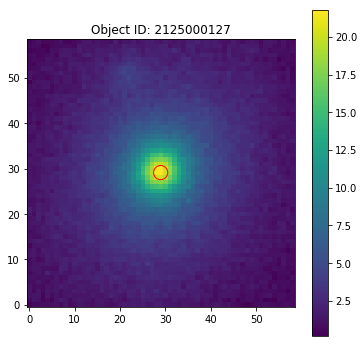

5


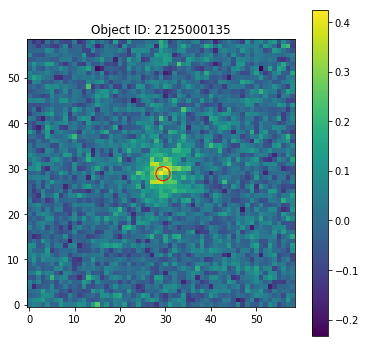

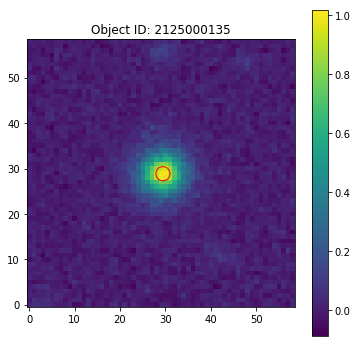

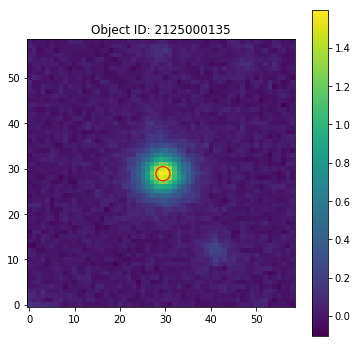

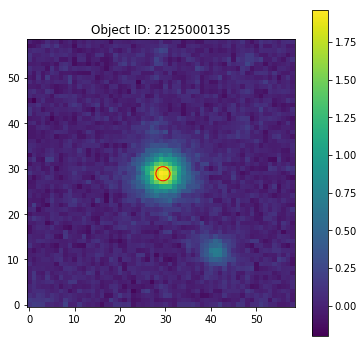

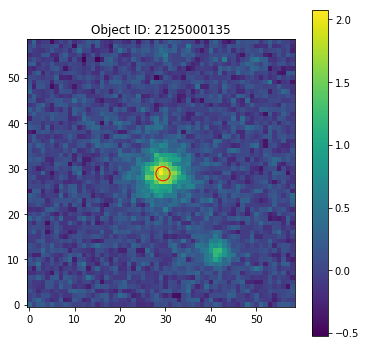

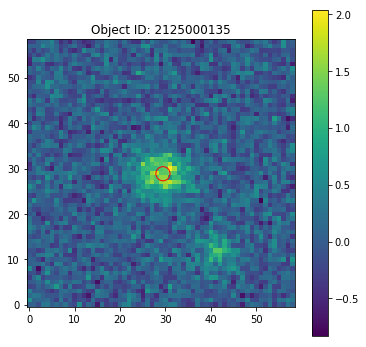

6


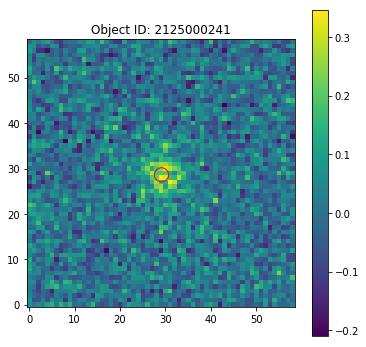

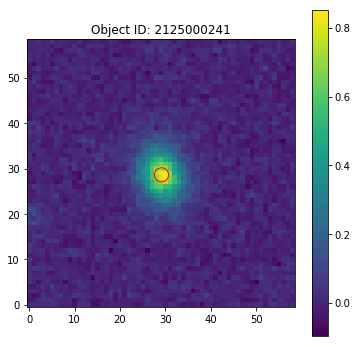

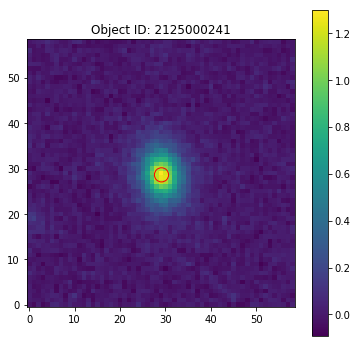

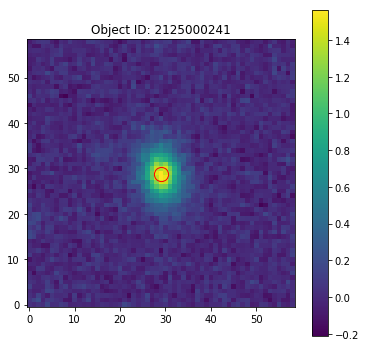

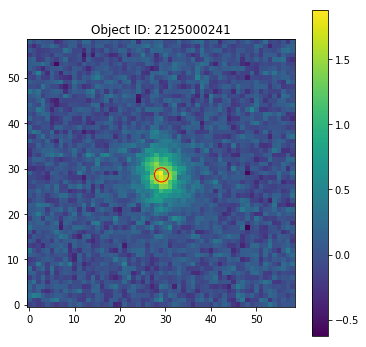

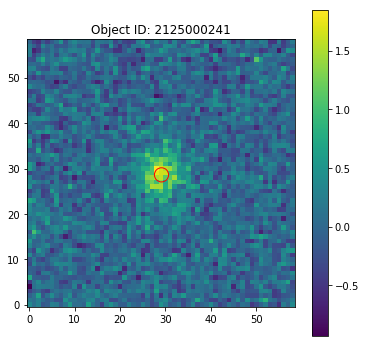

7


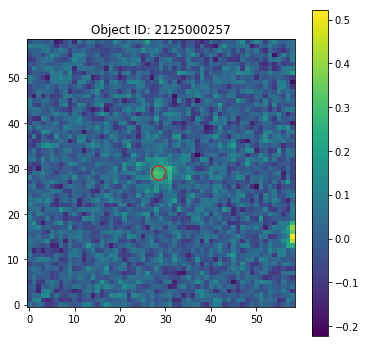

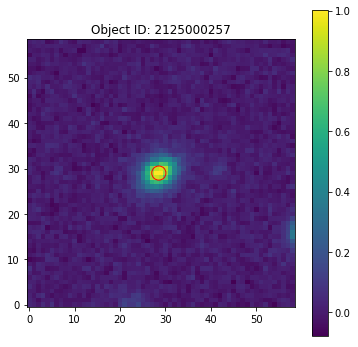

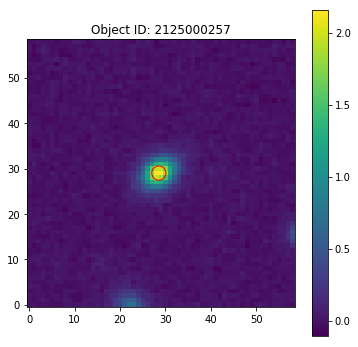

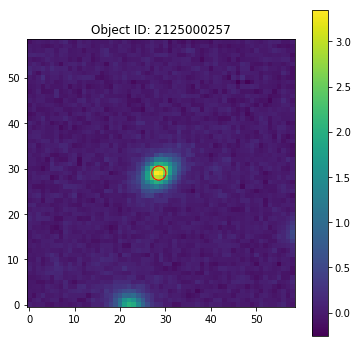

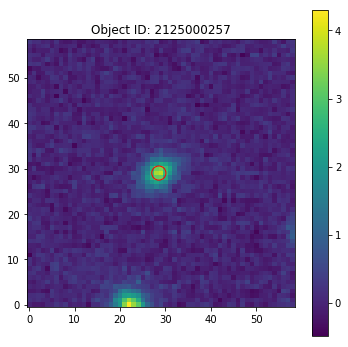

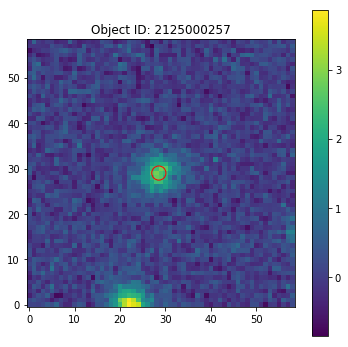

8


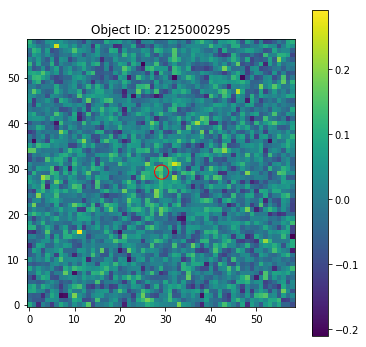

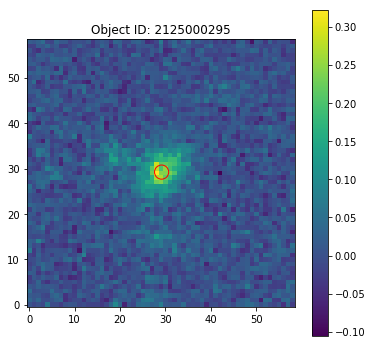

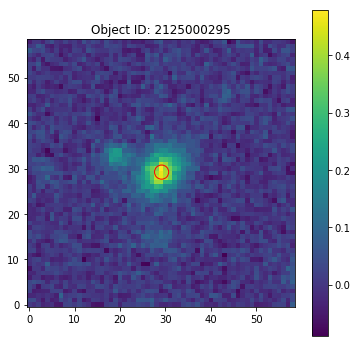

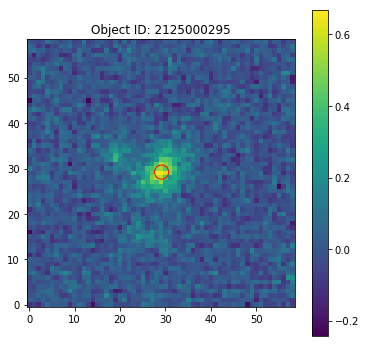

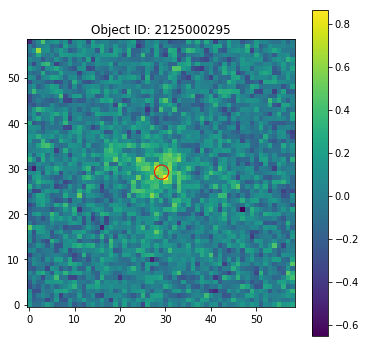

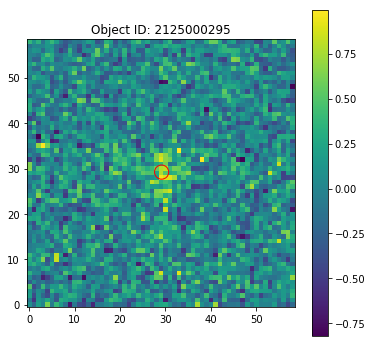

9


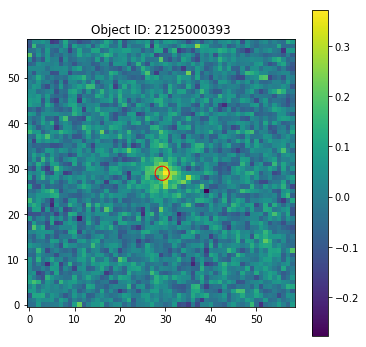

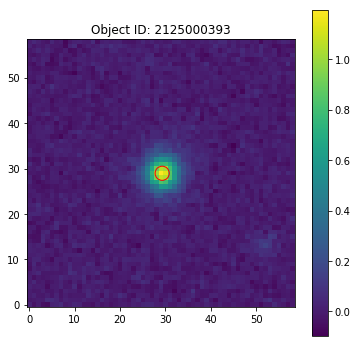

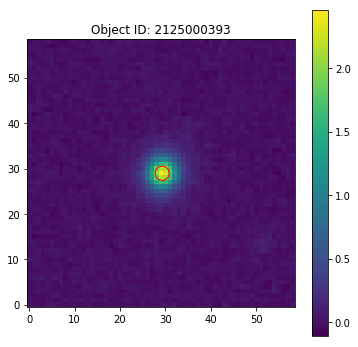

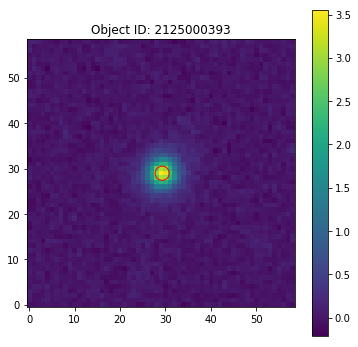

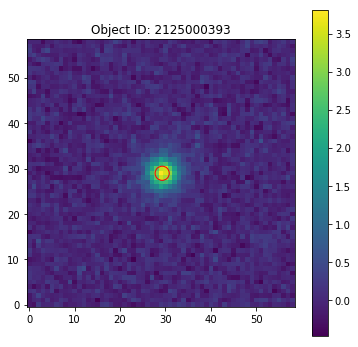

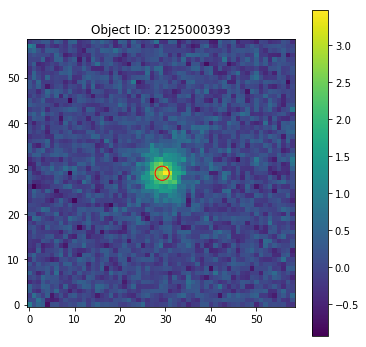

In [97]:
t_1 = time.time()
N = 10

img_sample = np.zeros((N,59,59,6))
psf_sample = np.zeros((N,59,59,6))

e1 = []
e2 = []
shear1=[]
shear2=[]
redshift=[]

for i in range (N):
    print(i)
    first = id_ra_dec[object_idx[i]]
    ra, dec = first['ra'], first['dec']
    # Necessary for PSF position
    radec = lsst.geom.SpherePoint(ra, dec, lsst.geom.degrees)
    xy = cutout.getWcs().skyToPixel(radec)  # returns a Point2D

    frame = 0
    plt.figure(frame)
    
    img = np.zeros((59,59,6))
    psf = np.zeros((59,59,6))
    filters = ['u','g','r','i','z','y']
    for k, filter_k in enumerate (filters):
        if k == 0:
            cutout = cutout_img_dc2.make_cutout_image(butler_u, ra, dec, filter=filter_k, label="Object ID: %d" % truth_data['galaxy_id'][truth_idx[i]])
        else:
            cutout = cutout_img_dc2.make_cutout_image(butler, ra, dec, filter=filter_k, label="Object ID: %d" % truth_data['galaxy_id'][truth_idx[i]])
        img[:,:,k]= cutout.image.array
        psf[:,:,k]= cutout.getPsf().computeKernelImage(xy).array
    
    img_sample[i]=img
    psf_sample[i]=psf
    
    e1.append(truth_data['ellipticity_1_true'][truth_idx[i]])
    e2.append(truth_data['ellipticity_2_true'][truth_idx[i]])
    shear1.append(truth_data['shear_1'][truth_idx[i]])
    shear2.append(truth_data['shear_2'][truth_idx[i]])
    redshift.append(truth_data['redshift'][truth_idx[i]])
    
t_2 = time.time()

In [98]:
t_2-t_1

136.4356164932251

Plot some images for test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


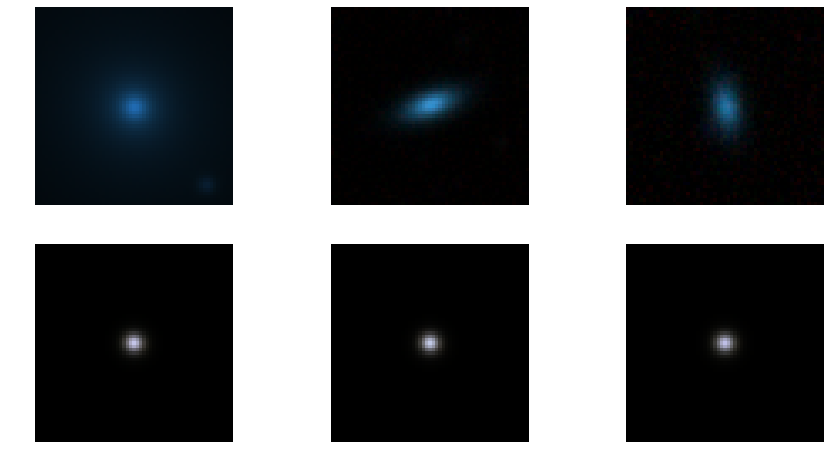

In [100]:
fig, axes  = plt.subplots(2,3, figsize = (15,8))

for i in range (3):
    # Image of galaxy scene
    plot.plot_rgb(img_sample[i]/np.max(img_sample[i]), bands=[0,1,2], ax=axes[0,i], band_first=False, zoom=1)
    # Corresponding PSF
    plot.plot_rgb(psf_sample[i]/np.max(psf_sample[i]), bands=[0,1,2], ax=axes[1,i], band_first=False, zoom=1)